<a href="https://colab.research.google.com/github/PassivelyIronic/umwdm_OCTMNIST_CNV_prediction/blob/main/umwdm_OCTMNIST_CNV_vs_NORMAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OCTMNIST - TRANSFER LEARNING: BINARY CLASSIFICATION (CNV vs NORMAL)

CEL PROJEKTU:
Klasyfikacja binarnych obrazów OCT (Optical Coherence Tomography) siatkówki
w celu automatycznej diagnostyki choroby CNV (Choroidal Neovascularization)
vs zdrowej siatkówki (NORMAL). Projekt wykorzystuje transfer learning (ResNet18)
do rozwiązania problemu diagnostycznego z ograniczoną ilością danych medycznych.

ZAKRES PROJEKTU:
1. Eksploracyjna analiza danych (EDA) - rozkład klas, wizualizacje
2. Preprocessing obrazów - CLAHE, Gaussian Blur, normalizacja
3. Balansowanie klas - WeightedRandomSampler
4. Transfer Learning - ResNet18 z pretrenowanymi wagami ImageNet
5. Tuning hiperparametrów - Optuna (15 trials)
6. Trening i walidacja modelu
7. Ewaluacja - confusion matrix, ROC curve, precision-recall curve
8. Zaawansowana wyjaśnialność - Grad-CAM, Saliency Maps, Integrated Gradients

In [3]:
# ============================================================================
# BLOK 0: SETUP I INSTALACJA
# ============================================================================

!pip install -q medmnist optuna torch torchvision matplotlib seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from collections import Counter
import os
import json
import pickle

from medmnist import OCTMNIST, INFO
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             precision_score, recall_score, f1_score)
import optuna

# Konfiguracja
CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [4]:
# ============================================================================
# CHECKPOINTy
# ============================================================================

def save_checkpoint(name, data):
    """Zapisuje checkpoint do pliku"""
    path = os.path.join(CHECKPOINT_DIR, f'{name}.pkl')
    with open(path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Checkpoint saved: {name}")

def load_checkpoint(name):
    """Wczytuje checkpoint z pliku"""
    path = os.path.join(CHECKPOINT_DIR, f'{name}.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            data = pickle.load(f)
        print(f"Checkpoint loaded: {name}")
        return data
    return None

def checkpoint_exists(name):
    """Sprawdza czy checkpoint istnieje"""
    path = os.path.join(CHECKPOINT_DIR, f'{name}.pkl')
    return os.path.exists(path)

In [5]:
# ============================================================================
# BLOK 1: WCZYTYWANIE I FILTROWANIE DANYCH
# ============================================================================

print("\n" + "="*60)
print("BLOK 1: LOADING DATA")
print("="*60)

# Próba wczytania z checkpointu
datasets_checkpoint = load_checkpoint('datasets')

if datasets_checkpoint:
    train_dataset = datasets_checkpoint['train']
    val_dataset = datasets_checkpoint['val']
    test_dataset = datasets_checkpoint['test']
    train_labels = datasets_checkpoint['train_labels']
else:
    train_dataset = OCTMNIST(split='train', download=True, transform=None)
    val_dataset = OCTMNIST(split='val', download=True, transform=None)
    test_dataset = OCTMNIST(split='test', download=True, transform=None)

    # Filtrowanie do klas binarnych (CNV=0, NORMAL=3)
    def filter_to_binary(dataset, keep_classes=[0, 3]):
        indices = [idx for idx, (_, label) in enumerate(dataset) if label in keep_classes]
        return Subset(dataset, indices)

    train_dataset = filter_to_binary(train_dataset)
    val_dataset = filter_to_binary(val_dataset)
    test_dataset = filter_to_binary(test_dataset)

    train_labels = np.array([train_dataset.dataset[idx][1] for idx in train_dataset.indices])

    save_checkpoint('datasets', {
        'train': train_dataset,
        'val': val_dataset,
        'test': test_dataset,
        'train_labels': train_labels
    })

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


BLOK 1: LOADING DATA


100%|██████████| 54.9M/54.9M [01:32<00:00, 595kB/s]


Checkpoint saved: datasets
Train: 79510 | Val: 8835 | Test: 500


In [6]:
# ============================================================================
# BLOK 2A: ANALIZA ROZKŁADU KLAS
# ============================================================================

print("\n" + "="*60)
print("BLOK 2A: CLASS DISTRIBUTION ANALYSIS")
print("="*60)

unique, counts = np.unique(train_labels, return_counts=True)
imbalance_ratio = np.max(counts) / np.min(counts)

print(f"CNV: {counts[0]:,} samples ({counts[0]/len(train_labels)*100:.1f}%)")
print(f"NORMAL: {counts[1]:,} samples ({counts[1]/len(train_labels)*100:.1f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")


BLOK 2A: CLASS DISTRIBUTION ANALYSIS
CNV: 33,484 samples (42.1%)
NORMAL: 46,026 samples (57.9%)
Imbalance ratio: 1.37:1


/tmp/ipython-input-3791280429.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=unique.flatten(), y=counts, palette='viridis')


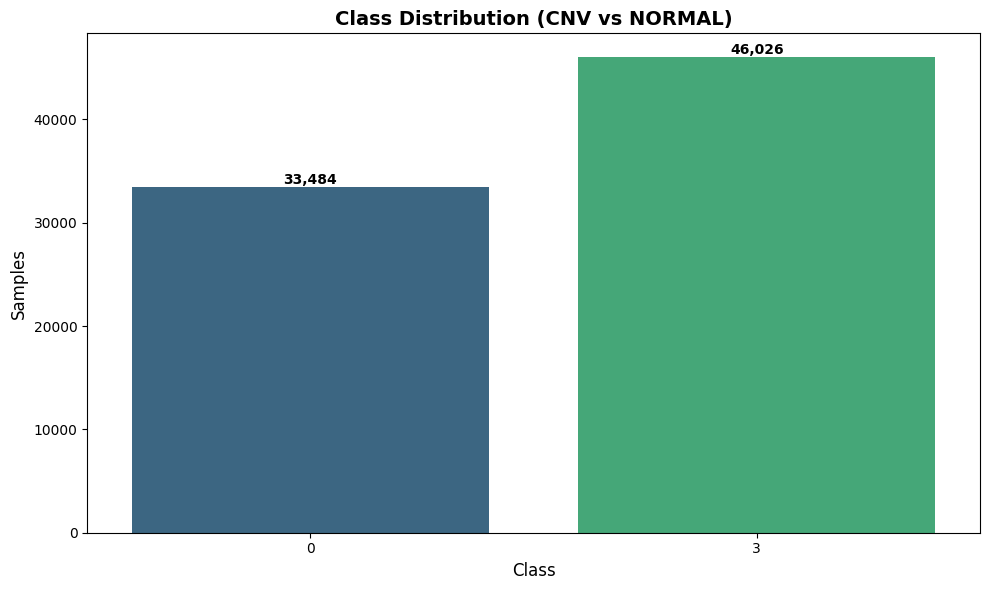

In [7]:
# ============================================================================
# BLOK 2B: WIZUALIZACJA ROZKŁADU
# ============================================================================

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=unique.flatten(), y=counts, palette='viridis')
plt.title("Class Distribution (CNV vs NORMAL)", fontsize=14, weight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Samples", fontsize=12)

for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

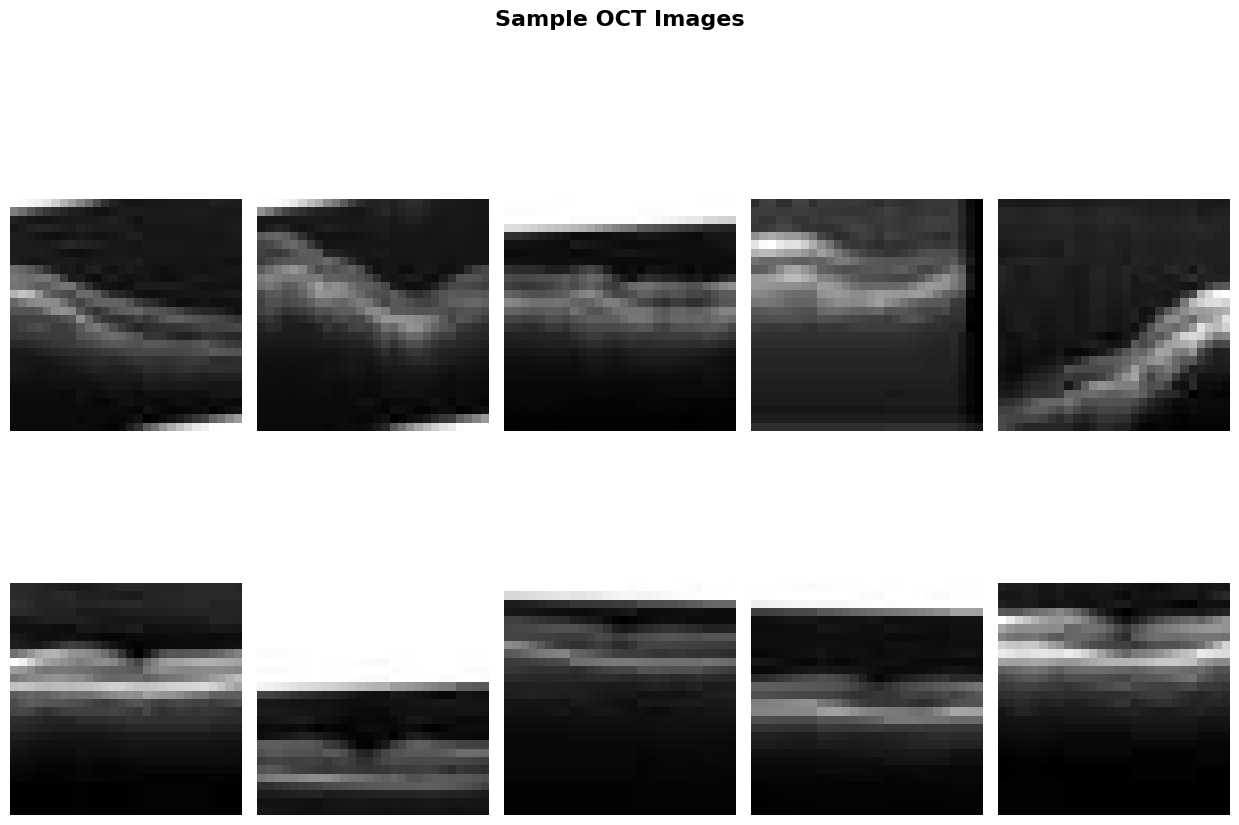

In [8]:
# ============================================================================
# BLOK 3: PRZYKŁADOWE OBRAZY
# ============================================================================

def show_samples(dataset, samples_per_class=5):
    classes = [0, 3]
    class_names = ['CNV', 'NORMAL']

    fig, axes = plt.subplots(2, samples_per_class, figsize=(samples_per_class*2.5, 10))
    fig.suptitle("Sample OCT Images", fontsize=16, weight='bold')

    for i, (cls, name) in enumerate(zip(classes, class_names)):
        indices = [idx for idx, (_, label) in enumerate(dataset) if label == cls]
        selected = np.random.choice(indices, min(samples_per_class, len(indices)), replace=False)

        for j, idx in enumerate(selected):
            img, _ = dataset[idx]
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(f"{name}", rotation=0, labelpad=40,
                                     fontsize=12, weight='bold')

    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [9]:
# ============================================================================
# BLOK 4: PREPROCESSING CLASSES
# ============================================================================

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        np_img = np.array(img)
        if len(np_img.shape) == 3:
            np_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)
        return Image.fromarray(self.clahe.apply(np_img))

class GaussianDenoise:
    def __init__(self, ksize=3):
        self.ksize = ksize

    def __call__(self, img):
        np_img = np.array(img)
        blurred = cv2.GaussianBlur(np_img, (self.ksize, self.ksize), 0)
        return Image.fromarray(blurred)

# Pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    GaussianDenoise(ksize=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

print("\n" + "="*60)
print("BLOK 4: PREPROCESSING APPLIED")
print("="*60)
print("Resize -> 256x256")
print("CLAHE -> contrast enhancement")
print("Gaussian Blur -> noise reduction")
print("Normalization -> [-1, 1]")


BLOK 4: PREPROCESSING APPLIED
Resize -> 256x256
CLAHE -> contrast enhancement
Gaussian Blur -> noise reduction
Normalization -> [-1, 1]


In [10]:
# ============================================================================
# BLOK 5: BALANSOWANIE KLAS I DATALOADER
# ============================================================================

print("\n" + "="*60)
print("BLOK 5: CLASS BALANCING")
print("="*60)

class_mapping = {0: 0, 3: 1}
targets = torch.tensor([int(train_dataset.dataset[idx][1]) for idx in train_dataset.indices])
targets_mapped = torch.tensor([class_mapping[int(t)] for t in targets])

class_weights = 1.0 / torch.tensor([counts[0], counts[1]], dtype=torch.float)
sample_weights = class_weights[targets_mapped]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoader
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"WeightedRandomSampler configured")
print(f"DataLoaders ready (batch_size={BATCH_SIZE})")


BLOK 5: CLASS BALANCING


/tmp/ipython-input-658143390.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets = torch.tensor([int(train_dataset.dataset[idx][1]) for idx in train_dataset.indices])


WeightedRandomSampler configured
DataLoaders ready (batch_size=64)


In [11]:
# ============================================================================
# BLOK 6: MODEL DEFINITION
# ============================================================================

print("\n" + "="*60)
print("BLOK 6: MODEL ARCHITECTURE")
print("="*60)

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=2, freeze_backbone=True, dropout=0.5):
        super(TransferLearningModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2,
                                       padding=3, bias=False)

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

print("ResNet18 Transfer Learning model defined")


BLOK 6: MODEL ARCHITECTURE
ResNet18 Transfer Learning model defined


In [12]:
# Usuń checkpointy przed blokiem Optuna
!rm -f checkpoints/datasets.pkl
!rm -f optuna_study.db

In [13]:
# ============================================================================
# BLOK 7: HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*60)
print("BLOK 7: HYPERPARAMETER TUNING")
print("="*60)

import os
import glob

# False dla wgrania z checkpointu
FORCE_NEW_TUNING = True

def map_labels(labels):
    """Mapowanie i spłaszczanie etykiet do formatu 1D"""
    mapped = torch.tensor([class_mapping[int(l)] for l in labels.cpu()], dtype=torch.long)
    return mapped.to(labels.device).view(-1)

def nuclear_clean_optuna():
    """Wyczyszczenie plików Optuna"""
    print("\nCleaning Optuna files...")

    removed_count = 0

    # pliki .db
    db_patterns = ['optuna*.db*', '*.db-journal', '*.db-wal', '*.db-shm']
    for pattern in db_patterns:
        for file in glob.glob(pattern):
            try:
                os.remove(file)
                print(f"  Removed: {file}")
                removed_count += 1
            except Exception as e:
                print(f"  Could not remove {file}: {e}")

    # Checkpoint pickle
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'optuna_study.pkl')
    if os.path.exists(checkpoint_path):
        try:
            os.remove(checkpoint_path)
            print(f"  Removed: optuna_study.pkl")
            removed_count += 1
        except Exception as e:
            print(f"  Could not remove checkpoint: {e}")

    print(f"  Cleanup complete ({removed_count} items)\n")

def objective(trial):
    """Funkcja objective dla Optuna"""
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.3, 0.7)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    model_trial = TransferLearningModel(
        num_classes=2,
        freeze_backbone=True,
        dropout=dropout
    ).to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model_trial.parameters()),
            lr=lr
        )
    else:
        optimizer = optim.SGD(
            filter(lambda p: p.requires_grad, model_trial.parameters()),
            lr=lr,
            momentum=0.9
        )

    criterion = nn.CrossEntropyLoss()

    max_batches = 20

    for epoch in range(3):
        model_trial.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            if batch_idx >= max_batches:
                break

            images = images.to(device)
            labels = map_labels(labels).to(device)

            optimizer.zero_grad()
            outputs = model_trial(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Walidacja
    model_trial.eval()
    correct, total = 0, 0
    max_val_batches = 10

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            if batch_idx >= max_val_batches:
                break

            images = images.to(device)
            labels = map_labels(labels).to(device)

            outputs = model_trial(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total if total > 0 else 0.0

    print(f"  Trial {trial.number:2d}: lr={lr:.2e}, dropout={dropout:.2f}, "
          f"{optimizer_name:4s} -> acc={accuracy:.4f}")

    return accuracy

if FORCE_NEW_TUNING:
    print("FORCE_NEW_TUNING = True")
    nuclear_clean_optuna()

optuna_checkpoint = load_checkpoint('optuna_study')

if optuna_checkpoint and not FORCE_NEW_TUNING:
    print("Loaded existing Optuna study from checkpoint")
    study = optuna_checkpoint['study']
    best_params = study.best_params
    print(f"\nUsing cached results ({len(study.trials)} trials)")

else:
    print("Creating NEW Optuna study...")
    print("   Storage: IN-MEMORY (no database files)")
    print("   Trials: 15")
    print("   Each trial: 3 epochs x 20 batches\n")

    study = optuna.create_study(
        study_name='octmnist_binary',
        storage=None,
        direction='maximize'
    )

    try:
        print("="*60)
        study.optimize(objective, n_trials=15, show_progress_bar=True)
        print("="*60)

        best_params = study.best_params

        save_checkpoint('optuna_study', {
            'study': study,
            'best_params': best_params
        })

        print("\nTuning complete and saved to checkpoint")

    except Exception as e:
        print(f"\nError during optimization: {e}")
        print("   Using default hyperparameters as fallback...")
        best_params = {
            'lr': 0.001,
            'dropout': 0.5,
            'optimizer': 'Adam'
        }
        study = optuna.create_study(direction='maximize', storage=None)

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"  Learning Rate:  {best_params['lr']:.6f}")
print(f"  Dropout:        {best_params['dropout']:.3f}")
print(f"  Optimizer:      {best_params['optimizer']}")

if hasattr(study, 'best_value'):
    print(f"  Best Val Acc:   {study.best_value:.4f}")
    print(f"  Total Trials:   {len(study.trials)}")

print("="*60)

db_files = glob.glob('optuna*.db*')
if db_files:
    print(f"\nWARNING: Found database files: {db_files}")
    print("   These should not exist with in-memory storage!")
else:
    print("\nVerified: No database files created (in-memory only)")

[I 2026-01-04 12:27:48,225] A new study created in memory with name: octmnist_binary



BLOK 7: HYPERPARAMETER TUNING
FORCE_NEW_TUNING = True

Cleaning Optuna files...
  Cleanup complete (0 items)

Creating NEW Optuna study...
   Storage: IN-MEMORY (no database files)
   Trials: 15
   Each trial: 3 epochs x 20 batches



  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 49%|████▉     | 22.0M/44.7M [00:00<00:00, 230MB/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


  Trial  0: lr=2.79e-05, dropout=0.46, Adam -> acc=0.5984
[I 2026-01-04 12:28:01,491] Trial 0 finished with value: 0.5984375 and parameters: {'lr': 2.786310599523723e-05, 'dropout': 0.46444086306222326, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5984375.
  Trial  1: lr=2.68e-05, dropout=0.42, SGD  -> acc=0.5641
[I 2026-01-04 12:28:12,933] Trial 1 finished with value: 0.5640625 and parameters: {'lr': 2.6786931606844464e-05, 'dropout': 0.4224121042312389, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5984375.
  Trial  2: lr=3.16e-03, dropout=0.57, Adam -> acc=0.8578
[I 2026-01-04 12:28:24,528] Trial 2 finished with value: 0.8578125 and parameters: {'lr': 0.0031633930135920815, 'dropout': 0.5670083185717515, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.8578125.
  Trial  3: lr=4.21e-05, dropout=0.32, SGD  -> acc=0.6125
[I 2026-01-04 12:28:36,125] Trial 3 finished with value: 0.6125 and parameters: {'lr': 4.210063440114483e-05, 'dropout': 0.3170726321177995, 'optimizer'

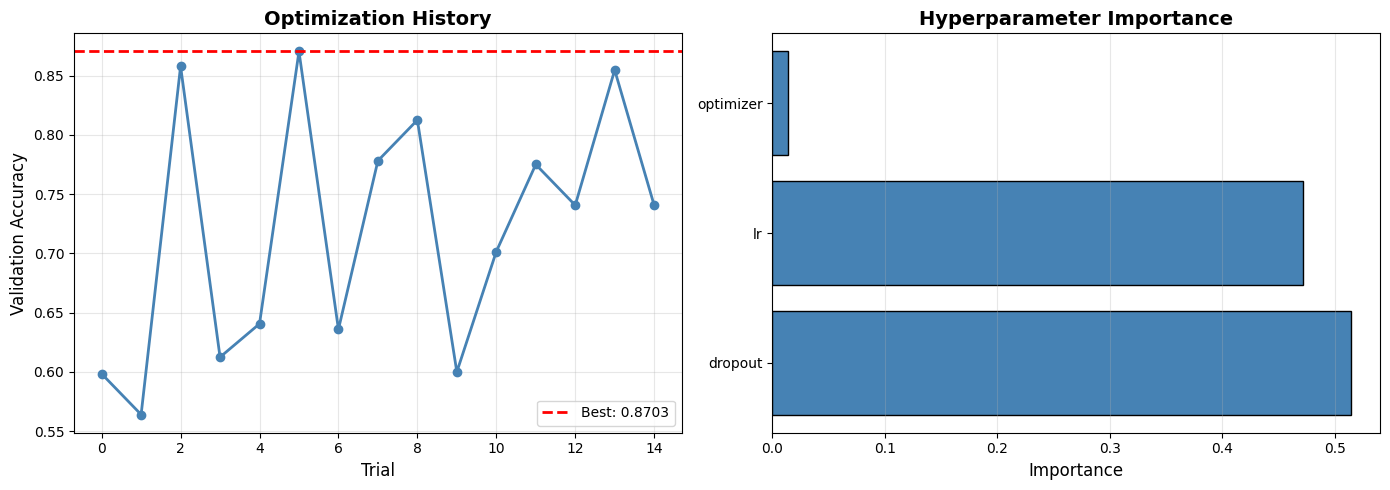

In [14]:
# ============================================================================
# BLOK 8: WIZUALIZACJA OPTUNA
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], marker='o', linewidth=2,
             markersize=6, color='steelblue')
axes[0].axhline(y=study.best_value, color='red', linestyle='--', linewidth=2,
                label=f'Best: {study.best_value:.4f}')
axes[0].set_xlabel('Trial', fontsize=12)
axes[0].set_ylabel('Validation Accuracy', fontsize=12)
axes[0].set_title('Optimization History', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

importance = optuna.importance.get_param_importances(study)
axes[1].barh(list(importance.keys()), list(importance.values()),
             color='steelblue', edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Hyperparameter Importance', fontsize=14, weight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [15]:
# ============================================================================
# BLOK 9: FINAL MODEL TRAINING
# ============================================================================

print("\n" + "="*60)
print("BLOK 9: FINAL MODEL TRAINING")
print("="*60)

# Próba wczytania z checkpointu
training_checkpoint = load_checkpoint('trained_model')

if training_checkpoint:
    model_final = TransferLearningModel(num_classes=2, freeze_backbone=True,
                                       dropout=training_checkpoint['dropout']).to(device)
    model_final.load_state_dict(training_checkpoint['model_state'])
    train_losses = training_checkpoint['train_losses']
    val_losses = training_checkpoint['val_losses']
    train_accs = training_checkpoint['train_accs']
    val_accs = training_checkpoint['val_accs']
    best_val_acc = training_checkpoint['best_val_acc']
    print("Model loaded from checkpoint")
else:
    model_final = TransferLearningModel(num_classes=2, freeze_backbone=True,
                                       dropout=best_params['dropout']).to(device)

    if best_params['optimizer'] == 'Adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_final.parameters()),
                              lr=best_params['lr'])
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_final.parameters()),
                             lr=best_params['lr'], momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                     factor=0.5, patience=3)

    NUM_EPOCHS = 5
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"Training for {NUM_EPOCHS} epochs...")

    for epoch in range(NUM_EPOCHS):
        model_final.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([class_mapping[int(l)] for l in labels.cpu()]).to(device).squeeze()

            optimizer.zero_grad()
            outputs = model_final(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        model_final.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = torch.tensor([class_mapping[int(l)] for l in labels.cpu()]).to(device).squeeze()

                outputs = model_final(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model_final.state_dict(), 'best_model_octmnist.pth')

        print(f'Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}')

    save_checkpoint('trained_model', {
        'model_state': model_final.state_dict(),
        'dropout': best_params['dropout'],
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    })

    print(f"\nTraining complete! Best Val Acc: {best_val_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



BLOK 9: FINAL MODEL TRAINING
Training for 5 epochs...


Epoch 1/5: 100%|██████████| 1243/1243 [05:24<00:00,  3.83it/s]


Epoch 1: Train Acc=0.8598 | Val Acc=0.9090


Epoch 2/5: 100%|██████████| 1243/1243 [05:25<00:00,  3.82it/s]


Epoch 2: Train Acc=0.8858 | Val Acc=0.9310


Epoch 3/5: 100%|██████████| 1243/1243 [05:25<00:00,  3.82it/s]


Epoch 3: Train Acc=0.8926 | Val Acc=0.9355


Epoch 4/5: 100%|██████████| 1243/1243 [05:23<00:00,  3.84it/s]


Epoch 4: Train Acc=0.8990 | Val Acc=0.9493


Epoch 5/5: 100%|██████████| 1243/1243 [05:24<00:00,  3.83it/s]


Epoch 5: Train Acc=0.9028 | Val Acc=0.9427
Checkpoint saved: trained_model

Training complete! Best Val Acc: 0.9493


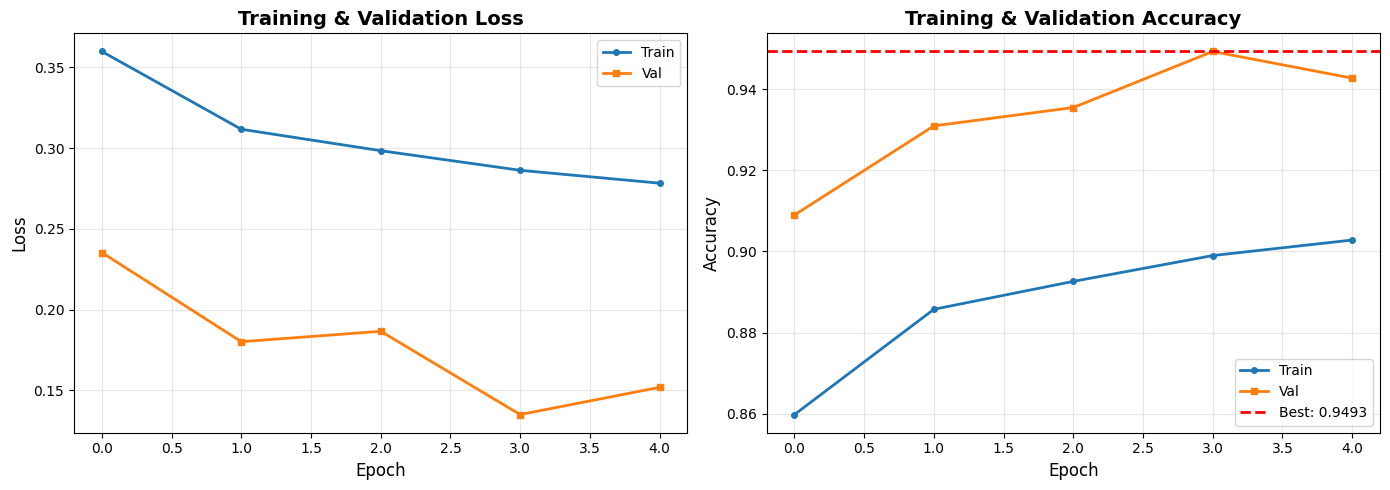

In [16]:
# ============================================================================
# BLOK 10: WIZUALIZACJA TRENINGU
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train', linewidth=2, marker='o', markersize=4)
axes[0].plot(val_losses, label='Val', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(train_accs, label='Train', linewidth=2, marker='o', markersize=4)
axes[1].plot(val_accs, label='Val', linewidth=2, marker='s', markersize=4)
axes[1].axhline(y=best_val_acc, color='red', linestyle='--', linewidth=2,
                label=f'Best: {best_val_acc:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# ============================================================================
# BLOK 11: EWALUACJA NA ZBIORZE TESTOWYM
# ============================================================================

print("\n" + "="*60)
print("BLOK 11: TEST SET EVALUATION")
print("="*60)

eval_checkpoint = load_checkpoint('evaluation_results')

if eval_checkpoint:
    all_preds = eval_checkpoint['all_preds']
    all_labels = eval_checkpoint['all_labels']
    all_probs = eval_checkpoint['all_probs']
    test_acc = eval_checkpoint['test_acc']
    print("Evaluation results loaded from checkpoint")
else:
    model_final.load_state_dict(torch.load('best_model_octmnist.pth'))
    model_final.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([class_mapping[int(l)] for l in labels.cpu()]).to(device).squeeze()

            outputs = model_final(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    test_acc = (all_preds == all_labels).sum() / len(all_labels)

    save_checkpoint('evaluation_results', {
        'all_preds': all_preds,
        'all_labels': all_labels,
        'all_probs': all_probs,
        'test_acc': test_acc
    })

print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


BLOK 11: TEST SET EVALUATION


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]

Checkpoint saved: evaluation_results

Test Accuracy: 0.9660 (96.60%)


In [18]:
# ============================================================================
# BLOK 12: CLASSIFICATION REPORT
# ============================================================================

print("\nClassification Report:")
print(classification_report(all_labels, all_preds,
                          target_names=['CNV', 'NORMAL'], digits=4))


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9533    0.9800    0.9665       250
      NORMAL     0.9794    0.9520    0.9655       250

    accuracy                         0.9660       500
   macro avg     0.9664    0.9660    0.9660       500
weighted avg     0.9664    0.9660    0.9660       500



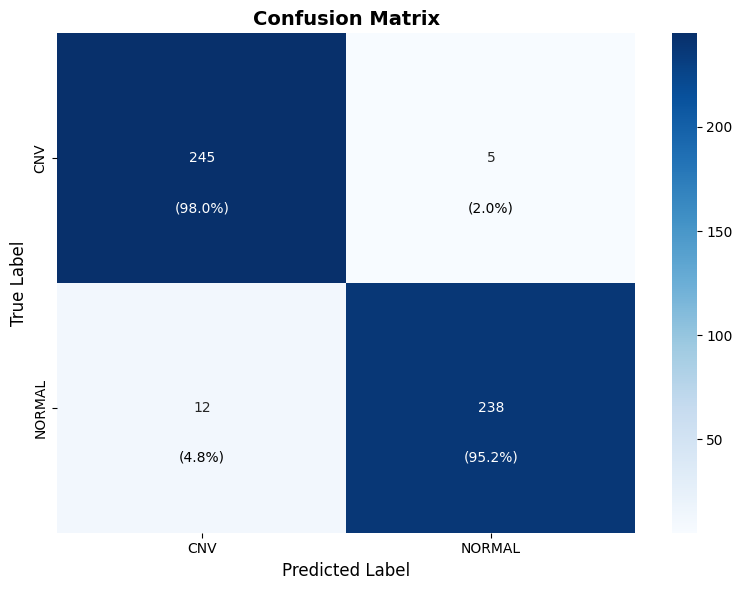

In [19]:
# ============================================================================
# BLOK 13: CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['CNV', 'NORMAL'],
            yticklabels=['CNV', 'NORMAL'])
plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

for i in range(2):
    for j in range(2):
        plt.text(j + 0.5, i + 0.7, f'({cm[i,j]/cm[i].sum()*100:.1f}%)',
                ha='center', va='center',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.tight_layout()
plt.show()

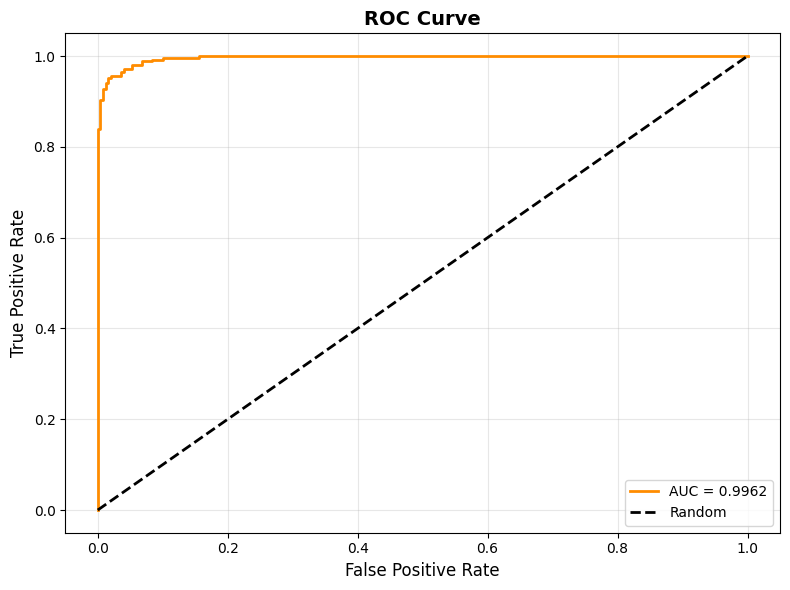

In [20]:
# ============================================================================
# BLOK 14: ROC CURVE
# ============================================================================

fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, weight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

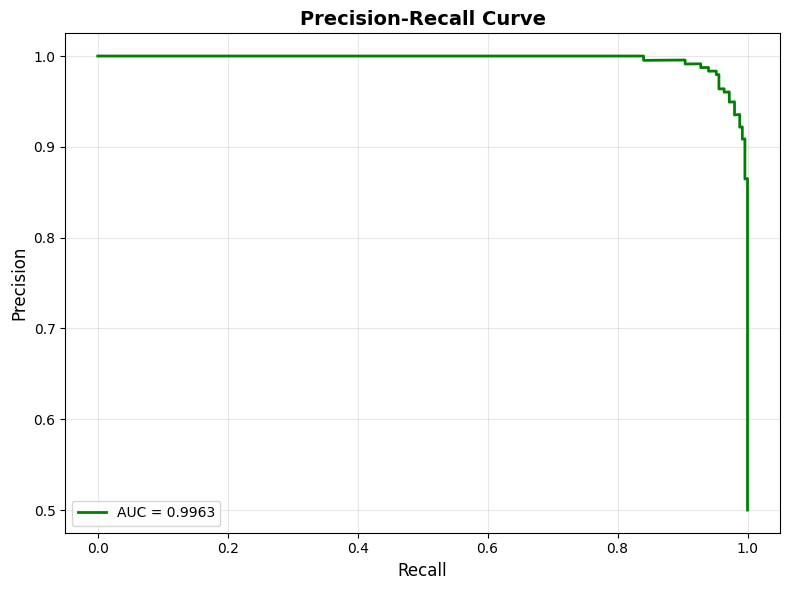

In [21]:
# ============================================================================
# BLOK 15: PRECISION-RECALL CURVE
# ============================================================================

precision, recall, _ = precision_recall_curve(all_labels, all_probs[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'AUC = {pr_auc:.4f}', color='green')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, weight='bold')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# ============================================================================
# BLOK 16: FINAL SUMMARY
# ============================================================================

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

print(f"\nModel: ResNet18 Transfer Learning")
print(f"Task: Binary Classification (CNV vs NORMAL)")
print(f"Best Val Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

print(f"\nSaved checkpoints:")
print(f"  - {CHECKPOINT_DIR}/datasets.pkl")
print(f"  - {CHECKPOINT_DIR}/optuna_study.pkl")
print(f"  - {CHECKPOINT_DIR}/trained_model.pkl")
print(f"  - {CHECKPOINT_DIR}/evaluation_results.pkl")
print(f"  - best_model_octmnist.pth")


FINAL RESULTS SUMMARY

Model: ResNet18 Transfer Learning
Task: Binary Classification (CNV vs NORMAL)
Best Val Accuracy: 0.9493
Test Accuracy: 0.9660
ROC AUC: 0.9962
PR AUC: 0.9963

Saved checkpoints:
  - checkpoints/datasets.pkl
  - checkpoints/optuna_study.pkl
  - checkpoints/trained_model.pkl
  - checkpoints/evaluation_results.pkl
  - best_model_octmnist.pth

Project complete!


In [23]:
# ============================================================================
# BLOK 17: ZAAWANSOWANA WYJAŚNIALNOŚĆ MODELU - DEFINICJE
# ============================================================================

print("\n" + "="*70)
print("BLOK 17: MODEL INTERPRETABILITY & EXPLAINABILITY")
print("="*70)

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2
from scipy.ndimage import gaussian_filter

# ============================================================================
# 1. GRAD-CAM IMPLEMENTATION
# ============================================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        self.model.eval()

        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)

        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (256, 256))

        return cam, target_class

# ============================================================================
# 2. SALIENCY MAPS
# ============================================================================

def generate_saliency_map(model, input_image, target_class=None):
    model.eval()
    input_image = input_image.clone().requires_grad_(True)

    output = model(input_image)

    if target_class is None:
        target_class = output.argmax(dim=1).item()

    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    saliency = input_image.grad.data.abs().squeeze()
    saliency = saliency.cpu().numpy()

    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

    return saliency, target_class

# ============================================================================
# 3. INTEGRATED GRADIENTS
# ============================================================================

def integrated_gradients(model, input_image, target_class=None, steps=50):
    model.eval()

    baseline = torch.zeros_like(input_image)

    with torch.no_grad():
        output = model(input_image)

    if target_class is None:
        target_class = output.argmax(dim=1).item()

    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline)
                     for i in range(steps + 1)]

    grads = []
    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.requires_grad_(True)
        output = model(scaled_input)

        model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        grads.append(scaled_input.grad.data.clone())

    avg_grads = torch.stack(grads).mean(dim=0)

    integrated_grad = (input_image - baseline) * avg_grads
    integrated_grad = integrated_grad.squeeze().abs().cpu().numpy()

    integrated_grad = (integrated_grad - integrated_grad.min()) / \
                      (integrated_grad.max() - integrated_grad.min() + 1e-8)

    return integrated_grad, target_class

# ============================================================================
# 4. OCCLUSION SENSITIVITY
# ============================================================================

def occlusion_sensitivity(model, input_image, target_class=None,
                          window_size=32, stride=16):

    model.eval()

    with torch.no_grad():
        original_output = model(input_image)

    if target_class is None:
        target_class = original_output.argmax(dim=1).item()

    original_prob = torch.softmax(original_output, dim=1)[0, target_class].item()

    h, w = input_image.shape[2], input_image.shape[3]
    sensitivity_map = np.zeros((h, w))

    for y in range(0, h - window_size, stride):
        for x in range(0, w - window_size, stride):
            occluded = input_image.clone()
            occluded[:, :, y:y+window_size, x:x+window_size] = 0

            with torch.no_grad():
                output = model(occluded)
                prob = torch.softmax(output, dim=1)[0, target_class].item()

            importance = original_prob - prob
            sensitivity_map[y:y+window_size, x:x+window_size] += importance

    sensitivity_map = (sensitivity_map - sensitivity_map.min()) / \
                      (sensitivity_map.max() - sensitivity_map.min() + 1e-8)

    sensitivity_map = gaussian_filter(sensitivity_map, sigma=3)

    return sensitivity_map, target_class

# ============================================================================
# 5. FUNKCJE POMOCNICZE - WIZUALIZACJA
# ============================================================================

def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):

    if isinstance(image, torch.Tensor):
        image = image.cpu().squeeze().numpy()

    image = (image * 0.5 + 0.5).clip(0, 1)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0

    image_rgb = np.stack([image] * 3, axis=-1)

    overlayed = (1 - alpha) * image_rgb + alpha * heatmap_colored

    return overlayed

def visualize_all_methods(model, image, label, prediction, prob,
                         grad_cam, sample_idx):

    device = next(model.parameters()).device
    img_tensor = image.unsqueeze(0).to(device)

    print(f"  Generating explanations for sample {sample_idx}...")

    cam, pred_class = grad_cam.generate_cam(img_tensor, prediction)
    saliency, _ = generate_saliency_map(model, img_tensor, prediction)
    ig, _ = integrated_gradients(model, img_tensor, prediction, steps=30)
    occl, _ = occlusion_sensitivity(model, img_tensor, prediction,
                                    window_size=24, stride=12)

    img_np = (image.cpu().squeeze().numpy() * 0.5 + 0.5).clip(0, 1)

    is_correct = (label == prediction)
    status = "CORRECT" if is_correct else "WRONG"
    status_color = 'green' if is_correct else 'red'

    class_names = ['CNV', 'NORMAL']

    fig = plt.figure(figsize=(20, 4))
    gs = GridSpec(1, 6, figure=fig, wspace=0.3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_np, cmap='gray')
    ax1.set_title(f"Original\nTrue: {class_names[label]}",
                  fontsize=10, weight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    overlay = overlay_heatmap(image, cam, alpha=0.5)
    ax2.imshow(overlay)
    ax2.set_title("Grad-CAM\n(Where model looks)",
                  fontsize=10, weight='bold')
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(saliency, cmap='hot')
    ax3.set_title("Saliency Map\n(Important pixels)",
                  fontsize=10, weight='bold')
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(ig, cmap='hot')
    ax4.set_title("Integrated Gradients\n(Stable attribution)",
                  fontsize=10, weight='bold')
    ax4.axis('off')

    ax5 = fig.add_subplot(gs[0, 4])
    ax5.imshow(occl, cmap='hot')
    ax5.set_title("Occlusion Sensitivity\n(Critical regions)",
                  fontsize=10, weight='bold')
    ax5.axis('off')

    ax6 = fig.add_subplot(gs[0, 5])
    ax6.axis('off')

    info_text = f"{status}\n\n"
    info_text += f"Pred: {class_names[prediction]}\n"
    info_text += f"Conf: {prob[prediction]:.1%}\n\n"
    info_text += f"Probabilities:\n"
    info_text += f"  CNV:    {prob[0]:.1%}\n"
    info_text += f"  NORMAL: {prob[1]:.1%}"

    ax6.text(0.1, 0.5, info_text, fontsize=10,
             verticalalignment='center',
             family='monospace',
             bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.2))

    plt.suptitle(f"Sample #{sample_idx} - Complete Explainability Analysis",
                 fontsize=14, weight='bold', y=0.98)

    return fig

print("Explainability functions defined")


BLOK 17: MODEL INTERPRETABILITY & EXPLAINABILITY
Explainability functions defined



BLOK 17A: BEST CASES ANALYSIS

Initializing explainability tools...
Grad-CAM initialized
Saliency Maps ready
Integrated Gradients ready
Occlusion Sensitivity ready

Collected 500 test samples

A. BEST CASES (High Confidence + Correct)

Statistics for correct predictions:
  Total correct:           483 / 500
  Mean confidence:         0.9679
  High confidence (>95%):  414 samples
  High confidence (>90%):  443 samples

Analyzing TOP 3 best predictions...

----------------------------------------------------------------------
BEST CASE #1 - Sample index: 317
----------------------------------------------------------------------
  True Label:     CNV
  Prediction:     CNV
  Confidence:     1.0000 (100.00%)
  CNV prob:       1.0000
  NORMAL prob:    0.0000
  Generating explanations for sample 317...


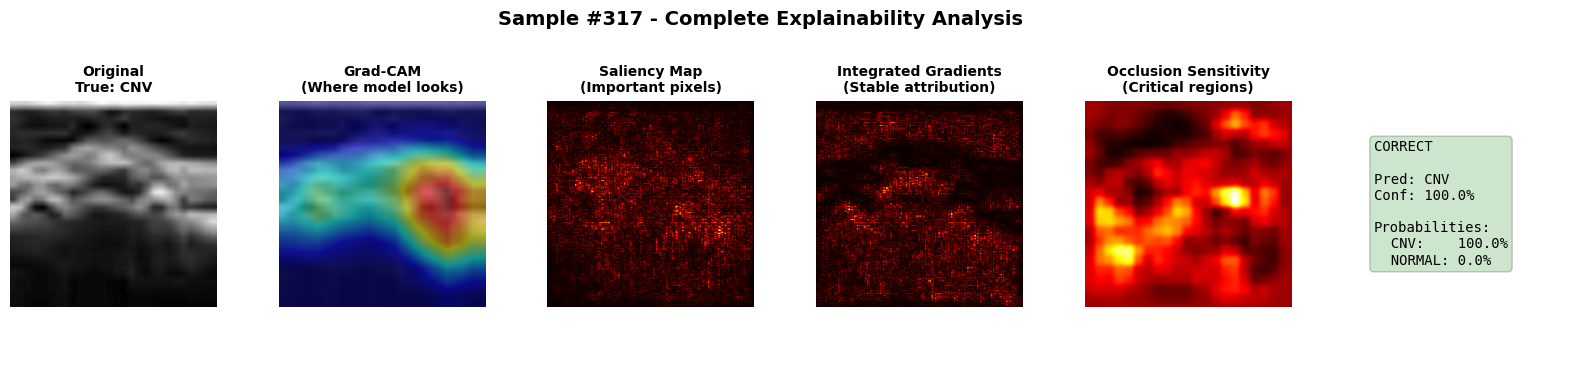


----------------------------------------------------------------------
BEST CASE #2 - Sample index: 260
----------------------------------------------------------------------
  True Label:     CNV
  Prediction:     CNV
  Confidence:     1.0000 (100.00%)
  CNV prob:       1.0000
  NORMAL prob:    0.0000
  Generating explanations for sample 260...


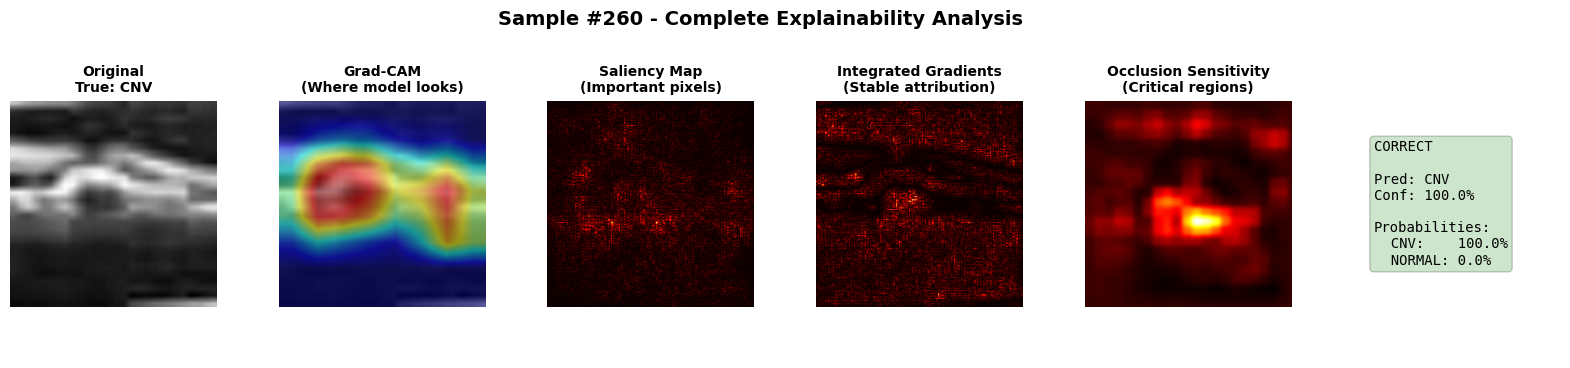


----------------------------------------------------------------------
BEST CASE #3 - Sample index: 369
----------------------------------------------------------------------
  True Label:     CNV
  Prediction:     CNV
  Confidence:     1.0000 (100.00%)
  CNV prob:       1.0000
  NORMAL prob:    0.0000
  Generating explanations for sample 369...


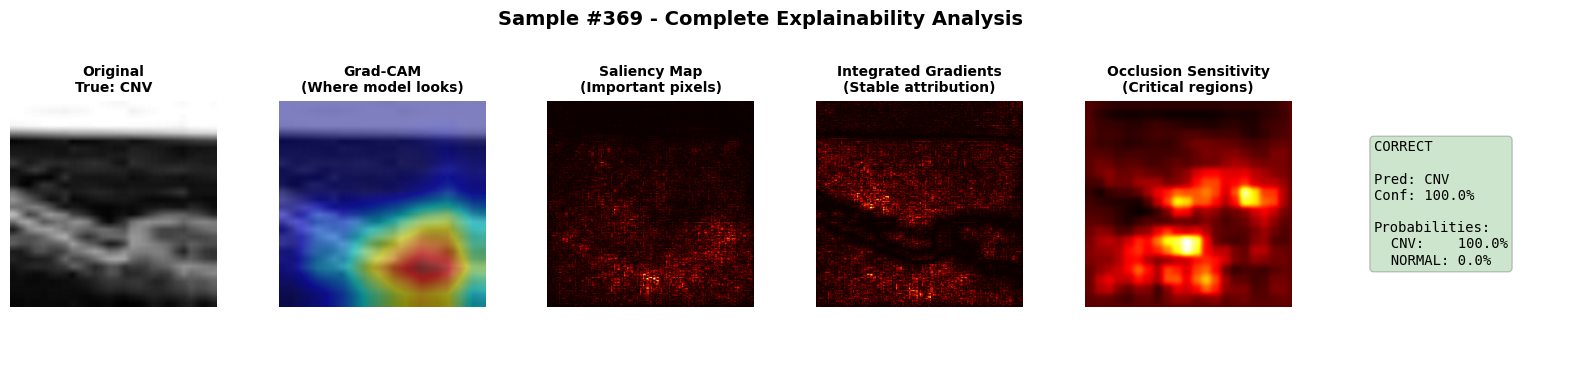


PER-CLASS ANALYSIS OF BEST CASES

CNV:
  Correct predictions:     245
  Mean confidence:         0.9731
  Max confidence:          1.0000
  Min confidence:          0.5247
  Confidence > 99%:        183 samples

NORMAL:
  Correct predictions:     238
  Mean confidence:         0.9625
  Max confidence:          1.0000
  Min confidence:          0.5423
  Confidence > 99%:        123 samples

Best cases analysis complete!


In [24]:
# ============================================================================
# BLOK 17A: NAJLEPSZE PRZYPADKI - HIGH CONFIDENCE + CORRECT
# ============================================================================

print("\n" + "="*70)
print("BLOK 17A: BEST CASES ANALYSIS")
print("="*70)

print("\nInitializing explainability tools...")

model_final.load_state_dict(torch.load('best_model_octmnist.pth'))
model_final.eval()

target_layer = model_final.backbone.layer4[-1].conv2
grad_cam = GradCAM(model_final, target_layer)

print("Grad-CAM initialized")
print("Saliency Maps ready")
print("Integrated Gradients ready")
print("Occlusion Sensitivity ready")

print("\nCollecting test set data...")

all_test_images = []
all_test_labels_full = []
all_test_preds_full = []
all_test_probs_full = []

model_final.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor([class_mapping[int(l)] for l in labels.cpu()]).to(device)

        outputs = model_final(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_test_images.extend(images.cpu())
        all_test_labels_full.extend(labels.cpu())
        all_test_preds_full.extend(predicted.cpu())
        all_test_probs_full.extend(probs.cpu())

all_test_images = torch.stack(all_test_images)
all_test_labels_full = torch.tensor(all_test_labels_full)
all_test_preds_full = torch.tensor(all_test_preds_full)
all_test_probs_full = torch.stack(all_test_probs_full)

print(f"Collected {len(all_test_images)} test samples")

print("\n" + "="*70)
print("A. BEST CASES (High Confidence + Correct)")
print("="*70)

correct_mask = (all_test_labels_full == all_test_preds_full)
correct_indices = torch.where(correct_mask)[0]

confidences = all_test_probs_full[range(len(all_test_preds_full)), all_test_preds_full]
correct_confidences = confidences[correct_mask]

print(f"\nStatistics for correct predictions:")
print(f"  Total correct:           {correct_mask.sum().item()} / {len(all_test_images)}")
print(f"  Mean confidence:         {correct_confidences.mean():.4f}")
print(f"  High confidence (>95%):  {(correct_confidences > 0.95).sum().item()} samples")
print(f"  High confidence (>90%):  {(correct_confidences > 0.90).sum().item()} samples")

sorted_correct = correct_indices[correct_confidences.argsort(descending=True)]

print(f"\nAnalyzing TOP 3 best predictions...")
print(f"{'='*70}")

for i, idx in enumerate(sorted_correct[:3]):
    idx = idx.item()

    true_label = all_test_labels_full[idx].item()
    pred_label = all_test_preds_full[idx].item()
    confidence = confidences[idx].item()
    class_names = ['CNV', 'NORMAL']

    print(f"\n{'-'*70}")
    print(f"BEST CASE #{i+1} - Sample index: {idx}")
    print(f"{'-'*70}")
    print(f"  True Label:     {class_names[true_label]}")
    print(f"  Prediction:     {class_names[pred_label]}")
    print(f"  Confidence:     {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  CNV prob:       {all_test_probs_full[idx][0]:.4f}")
    print(f"  NORMAL prob:    {all_test_probs_full[idx][1]:.4f}")

    fig = visualize_all_methods(
        model_final,
        all_test_images[idx],
        all_test_labels_full[idx].item(),
        all_test_preds_full[idx].item(),
        all_test_probs_full[idx].numpy(),
        grad_cam,
        idx
    )
    plt.show()
    plt.close()

print(f"\n{'='*70}")
print("PER-CLASS ANALYSIS OF BEST CASES")
print(f"{'='*70}")

for class_idx, class_name in enumerate(['CNV', 'NORMAL']):
    class_correct_mask = (all_test_labels_full == class_idx) & correct_mask
    class_correct_indices = torch.where(class_correct_mask)[0]
    class_confidences = confidences[class_correct_mask]

    if len(class_confidences) > 0:
        print(f"\n{class_name}:")
        print(f"  Correct predictions:     {len(class_confidences)}")
        print(f"  Mean confidence:         {class_confidences.mean():.4f}")
        print(f"  Max confidence:          {class_confidences.max():.4f}")
        print(f"  Min confidence:          {class_confidences.min():.4f}")
        print(f"  Confidence > 99%:        {(class_confidences > 0.99).sum().item()} samples")

print("\nBest cases analysis complete!")
print("="*70)


BLOK 17B: MISCLASSIFIED CASES ANALYSIS

Error Statistics:
  Total errors:            17 / 500
  Error rate:              3.40%
  Correct predictions:     483 (96.60%)

Error Confidence Analysis:
  Mean confidence (errors):    0.7318
  Max confidence (error):      0.9630
  Min confidence (error):      0.5006
  Errors with conf > 80%:      6 samples
  Errors with conf > 70%:      10 samples

Error Type Breakdown:
  False Positives (NORMAL->CNV): 12 (70.6% of errors)
  False Negatives (CNV->NORMAL): 5 (29.4% of errors)

Clinical Impact:
  CNV missed rate:         5/250 = 2.00%
  False alarm rate:        12/250 = 4.80%

ANALYZING 3 MOST CONFIDENT MISCLASSIFICATIONS

----------------------------------------------------------------------
ERROR CASE #1 - Sample index: 87
----------------------------------------------------------------------
  Error Type:     FALSE POSITIVE (False alarm)
  Severity:       MEDIUM RISK
  True Label:     NORMAL
  Prediction:     CNV
  Confidence:     0.9630 (96.

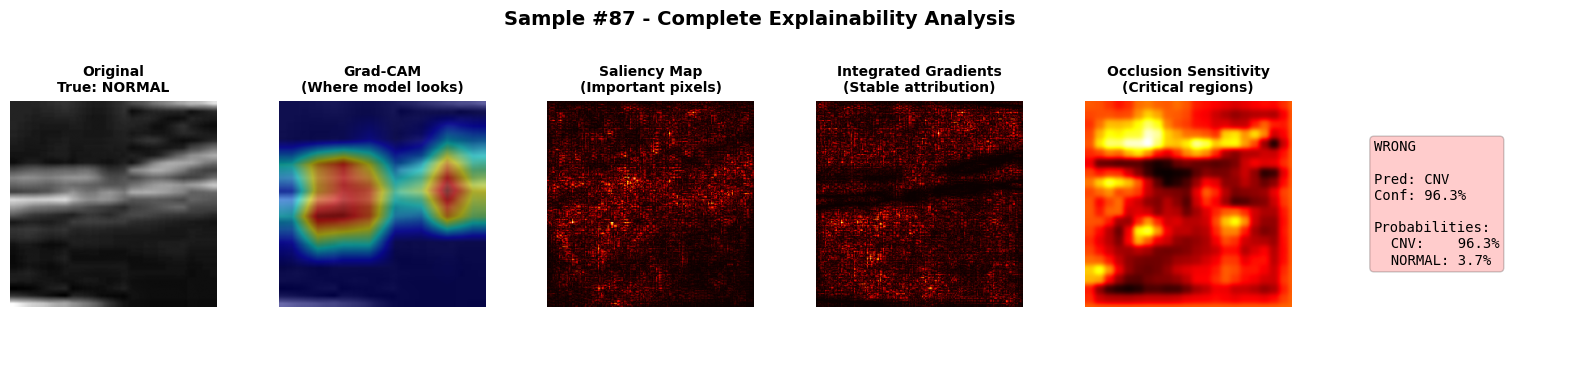


----------------------------------------------------------------------
ERROR CASE #2 - Sample index: 106
----------------------------------------------------------------------
  Error Type:     FALSE POSITIVE (False alarm)
  Severity:       MEDIUM RISK
  True Label:     NORMAL
  Prediction:     CNV
  Confidence:     0.9261 (92.61%)
  CNV prob:       0.9261
  NORMAL prob:    0.0739
  Generating explanations for sample 106...


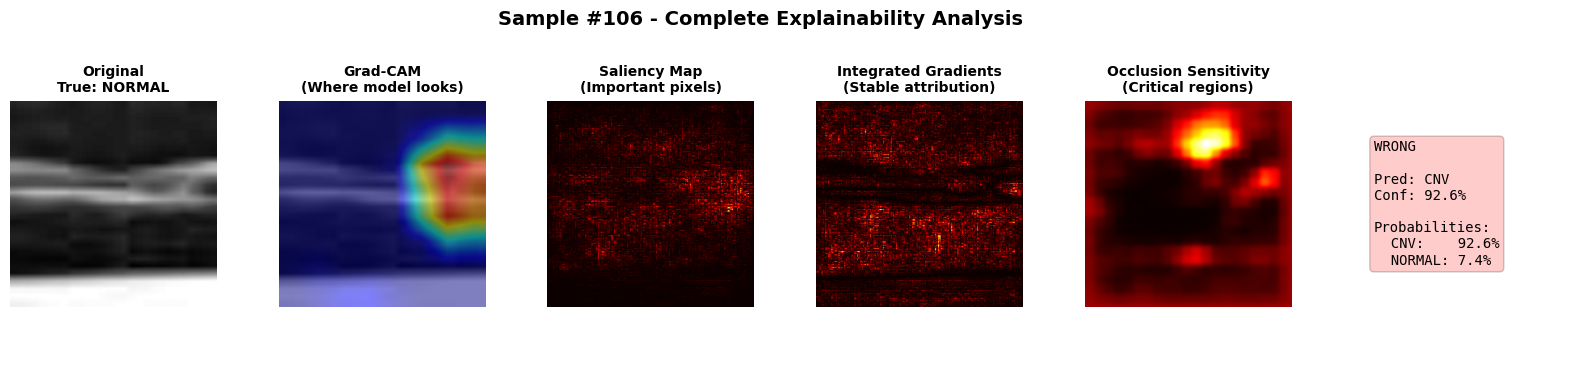


----------------------------------------------------------------------
ERROR CASE #3 - Sample index: 491
----------------------------------------------------------------------
  Error Type:     FALSE NEGATIVE (CNV missed)
  Severity:       HIGH RISK
  True Label:     CNV
  Prediction:     NORMAL
  Confidence:     0.9175 (91.75%)
  CNV prob:       0.0825
  NORMAL prob:    0.9175
  Generating explanations for sample 491...


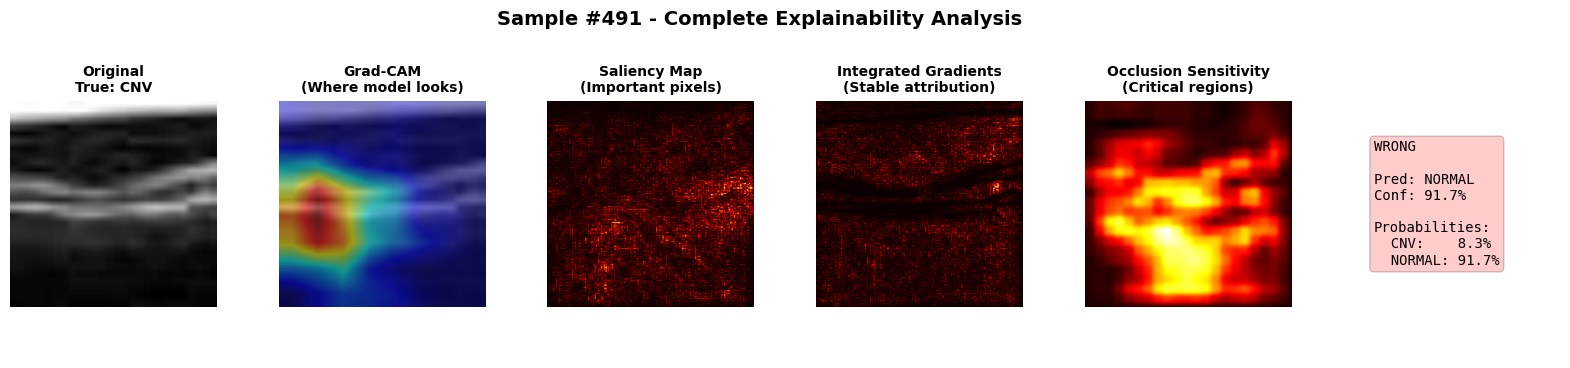


Error analysis complete!


In [25]:
# ============================================================================
# BLOK 17B: BŁĘDNE KLASYFIKACJE - ERROR ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("BLOK 17B: MISCLASSIFIED CASES ANALYSIS")
print("="*70)

error_mask = ~correct_mask
error_indices = torch.where(error_mask)[0]

total_errors = error_mask.sum().item()
error_rate = total_errors / len(all_test_images) * 100

print(f"\nError Statistics:")
print(f"  Total errors:            {total_errors} / {len(all_test_images)}")
print(f"  Error rate:              {error_rate:.2f}%")
print(f"  Correct predictions:     {correct_mask.sum().item()} ({(100-error_rate):.2f}%)")

if total_errors > 0:
    error_confidences = confidences[error_mask]

    print(f"\nError Confidence Analysis:")
    print(f"  Mean confidence (errors):    {error_confidences.mean():.4f}")
    print(f"  Max confidence (error):      {error_confidences.max():.4f}")
    print(f"  Min confidence (error):      {error_confidences.min():.4f}")
    print(f"  Errors with conf > 80%:      {(error_confidences > 0.80).sum().item()} samples")
    print(f"  Errors with conf > 70%:      {(error_confidences > 0.70).sum().item()} samples")

    print(f"\nError Type Breakdown:")

    false_positives = (all_test_labels_full == 1) & (all_test_preds_full == 0)
    fp_count = false_positives.sum().item()

    false_negatives = (all_test_labels_full == 0) & (all_test_preds_full == 1)
    fn_count = false_negatives.sum().item()

    print(f"  False Positives (NORMAL->CNV): {fp_count} ({fp_count/total_errors*100:.1f}% of errors)")
    print(f"  False Negatives (CNV->NORMAL): {fn_count} ({fn_count/total_errors*100:.1f}% of errors)")

    cnv_total = (all_test_labels_full == 0).sum().item()
    normal_total = (all_test_labels_full == 1).sum().item()

    print(f"\nClinical Impact:")
    print(f"  CNV missed rate:         {fn_count}/{cnv_total} = {fn_count/cnv_total*100:.2f}%")
    print(f"  False alarm rate:        {fp_count}/{normal_total} = {fp_count/normal_total*100:.2f}%")

    sorted_errors = error_indices[error_confidences.argsort(descending=True)]

    num_errors_to_show = min(3, len(sorted_errors))

    print(f"\n{'='*70}")
    print(f"ANALYZING {num_errors_to_show} MOST CONFIDENT MISCLASSIFICATIONS")
    print(f"{'='*70}")

    for i, idx in enumerate(sorted_errors[:num_errors_to_show]):
        idx = idx.item()

        true_label = all_test_labels_full[idx].item()
        pred_label = all_test_preds_full[idx].item()
        confidence = confidences[idx].item()
        class_names = ['CNV', 'NORMAL']

        if true_label == 0 and pred_label == 1:
            error_type = "FALSE NEGATIVE (CNV missed)"
            severity = "HIGH RISK"
        else:
            error_type = "FALSE POSITIVE (False alarm)"
            severity = "MEDIUM RISK"

        print(f"\n{'-'*70}")
        print(f"ERROR CASE #{i+1} - Sample index: {idx}")
        print(f"{'-'*70}")
        print(f"  Error Type:     {error_type}")
        print(f"  Severity:       {severity}")
        print(f"  True Label:     {class_names[true_label]}")
        print(f"  Prediction:     {class_names[pred_label]}")
        print(f"  Confidence:     {confidence:.4f} ({confidence*100:.2f}%)")
        print(f"  CNV prob:       {all_test_probs_full[idx][0]:.4f}")
        print(f"  NORMAL prob:    {all_test_probs_full[idx][1]:.4f}")

        fig = visualize_all_methods(
            model_final,
            all_test_images[idx],
            all_test_labels_full[idx].item(),
            all_test_preds_full[idx].item(),
            all_test_probs_full[idx].numpy(),
            grad_cam,
            idx
        )
        plt.show()
        plt.close()

else:
    print("\nPERFECT ACCURACY!")
    print("No misclassified samples in test set (100% accuracy)")
    print("This is exceptional performance for medical imaging!")

print("\nError analysis complete!")
print("="*70)


BLOK 17C: UNCERTAIN CASES ANALYSIS

Uncertainty Statistics:
  Uncertainty threshold:       0.70 (70%)
  Uncertain cases (correct):   12 / 483
  Percentage of correct:       2.48%
  Percentage of total:         2.40%

Confidence Distribution (Uncertain Cases):
  Mean confidence:         0.5963
  Max confidence:          0.6784
  Min confidence:          0.5247
  Cases 60-70% conf:       5
  Cases 50-60% conf:       7
  Cases <50% conf:         0

Per-Class Uncertainty Breakdown:

  CNV:
    Uncertain cases:       6
    Mean confidence:       0.5812
    Min confidence:        0.5247

  NORMAL:
    Uncertain cases:       6
    Mean confidence:       0.6114
    Min confidence:        0.5423

ANALYZING 3 MOST UNCERTAIN PREDICTIONS

----------------------------------------------------------------------
UNCERTAIN CASE #1 - Sample index: 371
----------------------------------------------------------------------
  Uncertainty Level:  VERY HIGH (near 50-50)
  True Label:         CNV
  Predictio

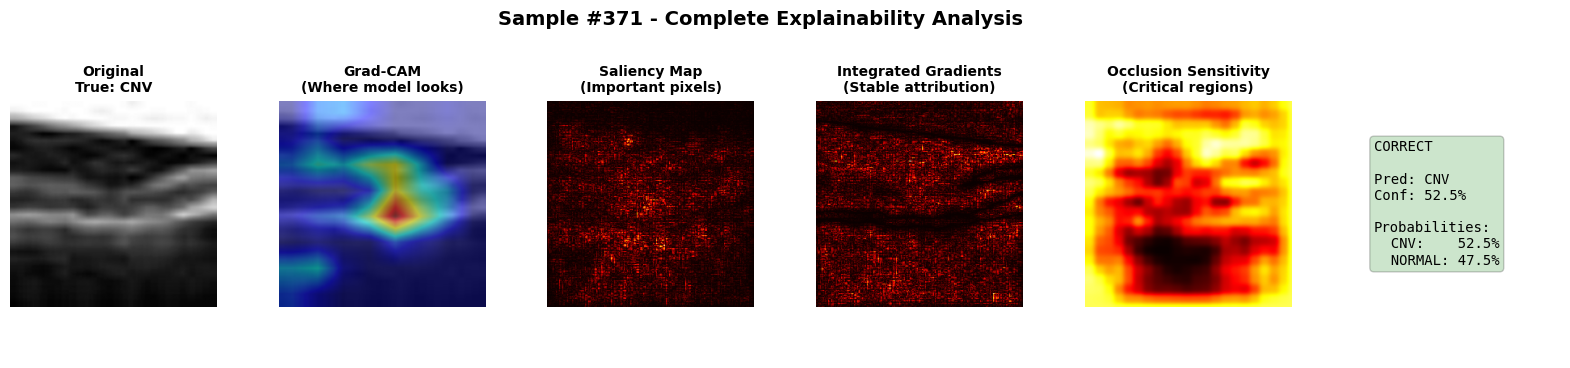


----------------------------------------------------------------------
UNCERTAIN CASE #2 - Sample index: 216
----------------------------------------------------------------------
  Uncertainty Level:  VERY HIGH (near 50-50)
  True Label:         NORMAL
  Prediction:         NORMAL (CORRECT)
  Confidence:         0.5423 (54.23%)
  CNV prob:           0.4577
  NORMAL prob:        0.5423
  Probability diff:   0.0846
  Generating explanations for sample 216...


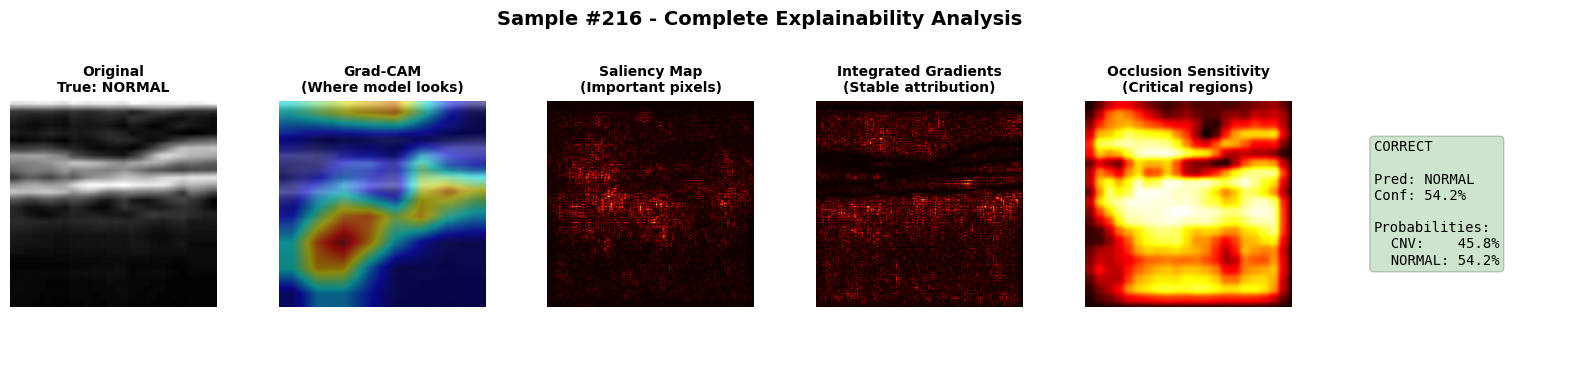


----------------------------------------------------------------------
UNCERTAIN CASE #3 - Sample index: 478
----------------------------------------------------------------------
  Uncertainty Level:  HIGH (close decision)
  True Label:         CNV
  Prediction:         CNV (CORRECT)
  Confidence:         0.5552 (55.52%)
  CNV prob:           0.5552
  NORMAL prob:        0.4448
  Probability diff:   0.1104
  Generating explanations for sample 478...


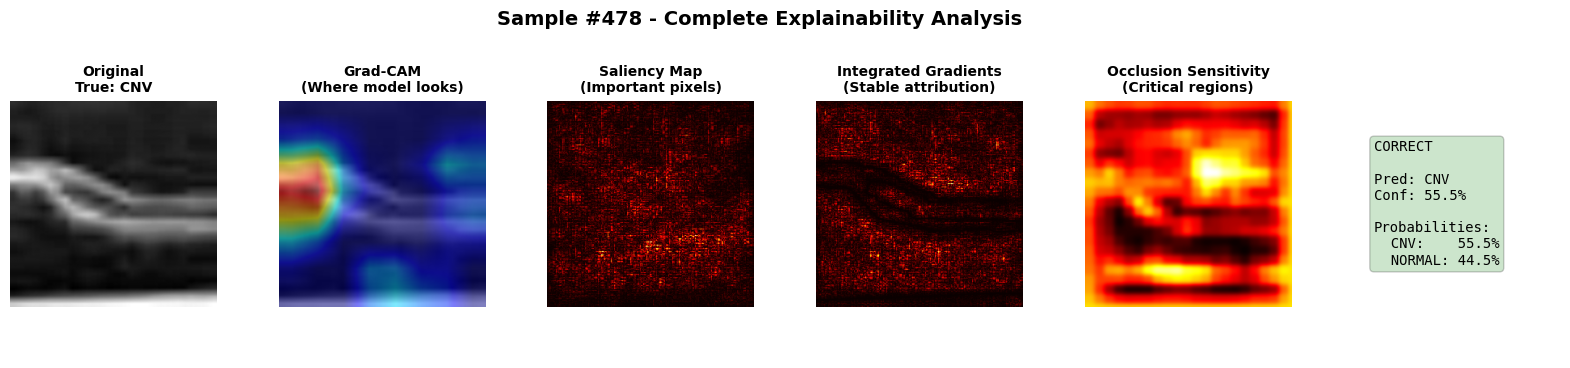


Uncertain cases analysis complete!


In [26]:
# ============================================================================
# BLOK 17C: TRUDNE PRZYPADKI - LOW CONFIDENCE BUT CORRECT
# ============================================================================

print("\n" + "="*70)
print("BLOK 17C: UNCERTAIN CASES ANALYSIS")
print("="*70)

UNCERTAINTY_THRESHOLD = 0.70

low_conf_correct = correct_indices[correct_confidences < UNCERTAINTY_THRESHOLD]
low_conf_values = confidences[low_conf_correct]

print(f"\nUncertainty Statistics:")
print(f"  Uncertainty threshold:       {UNCERTAINTY_THRESHOLD:.2f} ({UNCERTAINTY_THRESHOLD*100:.0f}%)")
print(f"  Uncertain cases (correct):   {len(low_conf_correct)} / {len(correct_indices)}")
print(f"  Percentage of correct:       {len(low_conf_correct)/len(correct_indices)*100:.2f}%")
print(f"  Percentage of total:         {len(low_conf_correct)/len(all_test_images)*100:.2f}%")

if len(low_conf_correct) > 0:
    print(f"\nConfidence Distribution (Uncertain Cases):")
    print(f"  Mean confidence:         {low_conf_values.mean():.4f}")
    print(f"  Max confidence:          {low_conf_values.max():.4f}")
    print(f"  Min confidence:          {low_conf_values.min():.4f}")
    print(f"  Cases 60-70% conf:       {((low_conf_values >= 0.60) & (low_conf_values < 0.70)).sum().item()}")
    print(f"  Cases 50-60% conf:       {((low_conf_values >= 0.50) & (low_conf_values < 0.60)).sum().item()}")
    print(f"  Cases <50% conf:         {(low_conf_values < 0.50).sum().item()}")

    print(f"\nPer-Class Uncertainty Breakdown:")

    for class_idx, class_name in enumerate(['CNV', 'NORMAL']):
        class_uncertain_mask = (all_test_labels_full[low_conf_correct] == class_idx)
        class_uncertain_count = class_uncertain_mask.sum().item()

        if class_uncertain_count > 0:
            class_uncertain_confs = low_conf_values[class_uncertain_mask]
            print(f"\n  {class_name}:")
            print(f"    Uncertain cases:       {class_uncertain_count}")
            print(f"    Mean confidence:       {class_uncertain_confs.mean():.4f}")
            print(f"    Min confidence:        {class_uncertain_confs.min():.4f}")

    sorted_uncertain = low_conf_correct[low_conf_values.argsort()]

    num_uncertain = min(3, len(sorted_uncertain))

    print(f"\n{'='*70}")
    print(f"ANALYZING {num_uncertain} MOST UNCERTAIN PREDICTIONS")
    print(f"{'='*70}")

    for i, idx in enumerate(sorted_uncertain[:num_uncertain]):
        idx = idx.item()

        true_label = all_test_labels_full[idx].item()
        pred_label = all_test_preds_full[idx].item()
        confidence = confidences[idx].item()
        class_names = ['CNV', 'NORMAL']

        cnv_prob = all_test_probs_full[idx][0].item()
        normal_prob = all_test_probs_full[idx][1].item()
        prob_diff = abs(cnv_prob - normal_prob)

        if prob_diff < 0.10:
            uncertainty_level = "VERY HIGH (near 50-50)"
        elif prob_diff < 0.20:
            uncertainty_level = "HIGH (close decision)"
        else:
            uncertainty_level = "MODERATE (borderline)"

        print(f"\n{'-'*70}")
        print(f"UNCERTAIN CASE #{i+1} - Sample index: {idx}")
        print(f"{'-'*70}")
        print(f"  Uncertainty Level:  {uncertainty_level}")
        print(f"  True Label:         {class_names[true_label]}")
        print(f"  Prediction:         {class_names[pred_label]} (CORRECT)")
        print(f"  Confidence:         {confidence:.4f} ({confidence*100:.2f}%)")
        print(f"  CNV prob:           {cnv_prob:.4f}")
        print(f"  NORMAL prob:        {normal_prob:.4f}")
        print(f"  Probability diff:   {prob_diff:.4f}")

        fig = visualize_all_methods(
            model_final,
            all_test_images[idx],
            all_test_labels_full[idx].item(),
            all_test_preds_full[idx].item(),
            all_test_probs_full[idx].numpy(),
            grad_cam,
            idx
        )
        plt.show()
        plt.close()

else:
    print("\nNO UNCERTAIN CASES FOUND!")
    print(f"All correct predictions have confidence >= {UNCERTAINTY_THRESHOLD*100:.0f}%")
    print("This indicates excellent model calibration and decision certainty.")

print("\nUncertain cases analysis complete!")
print("="*70)